In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from mpmath import *
from sympy import *
from numpy import linalg as LA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from random import randint, uniform

In [2]:
def get_adv_by_model_norm(X, Y_true, model=None, attack=None, norm=0.1):
    X_adv = None
    
    atck = attack()
    if type(atck).__name__ in ['AttackNoise']:
        X_adv = [atck.attack(X[i, :].reshape(1,-1), Y_true[i], model.predict, max_norm=norm)
                 for i in range(X.shape[0])]
    
    elif type(atck).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackDeepFool', 'AttackFGSM']:
        X_adv = [atck.attack(X[i, :].reshape(1,-1), model.W, model.b, Y_true[i, :], model.predict, max_norm=norm)
                 for i in range(X.shape[0])]
    
    elif type(atck).__name__ in ['AttackMIFGSM']:
        X_adv = [atck.attack(X[i, :].reshape(1,-1), model.W, model.b, Y_true[i], model.predict, max_norm=norm, momentum=0.95)
                 for i in range(X.shape[0])]

    return np.array(X_adv).reshape(X.shape[0], -1)

def benchmark_defense_by_model(X, Y_true, y_true, model=None, attack=None, samples=100, num_steps=0, a=0, b=0.5):
    norms = np.linspace(a, b, num=num_steps)
    scores = np.zeros(norms.shape)

    for idx, norm in enumerate(norms):
        X_normalize = normalize(X[0:samples])
        y_true = y_true[0:samples].reshape(samples)

        X_adv = get_adv_by_model_norm(X_normalize, Y_true, model=lg, attack=attack, norm=norm)
        scores[idx] = accuracy_score(model.predict(X_adv), y_true)
    return norms, scores, attack.__name__

def benchmark_defense_models_visual(X, Y_true, y_true, model=None, attack=None, samples=100, num_steps=10):
    x1, y1, label1 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackFGSM, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackIFGSM, samples=samples, num_steps=num_steps)
    #x3, y3, label3 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackMIFGSM, samples=samples, num_steps=num_steps)
    x4, y4, label4 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackDeepFool, samples=samples, num_steps=num_steps)

    fig, ax = plt.subplots(num=None, figsize=(12, 6), dpi=100, facecolor='w')
    plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
    ax.set_title('Perturbation vs Accuracy Rate')
    ax.set_xlabel(r"Perturbation $\epsilon$")
    ax.set_ylabel('Accuracy (%)')

    plt.plot(np.array(x1), y1, linestyle='--', marker='o', markersize=2, color='#00A658', label = label1)
    plt.plot(np.array(x2), y2, linestyle='--', marker='o', markersize=2, color='#2300A8', label = label2)
    #plt.plot(np.array(x3), y3, linestyle='--', marker='o', markersize=2, color='red', label = label3)
    plt.plot(np.array(x4), y4, linestyle='--', marker='o', markersize=2, color='orange', label = label4)

    plt.legend()

def compare_model_for_two_inputs(X1, X2, Y_true, y_true, model=None, attack=None, samples=100, num_steps=10, visualize=True):
    x1, y1, label1 = benchmark_defense_by_model(X1, Y_true, y_true, model=model, attack=attack, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_defense_by_model(X2, Y_true, y_true, model=model, attack=attack, samples=samples, num_steps=num_steps)
    
    if visualize:
        fig, ax = plt.subplots(num=None, figsize=(12, 6), dpi=100, facecolor='w')
        plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
        ax.set_title('Perturbation vs Accuracy Rate')
        ax.set_xlabel(r"Perturbation $\epsilon$")
        ax.set_ylabel('Accuracy (%)')

        plt.plot(x1, y1, linestyle='--', marker='o', markersize=2, color='#00A658', label = f"clean_{label1}")
        plt.plot(x2, y2, linestyle='--', marker='o', markersize=2, color='#2300A8', label = f"defended_{label2}")
        plt.legend()
    print(round(sum(y1/num_steps), 3), " : ", round(sum(y2/num_steps), 3))        
    a = round(sum(y1/num_steps), 4)
    b = round(sum(y2/num_steps), 4)
    return a,b


In [3]:
from matplotlib.pyplot import figure
from numpy.random import randint
from sklearn.metrics import accuracy_score

In [4]:
normalization = 255
width = 28
heigth = 28

In [5]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [6]:
def normalize(X):
    return X / normalization

In [7]:
def denormalize(X):
    return X * normalization

In [8]:
def to_image_shape(X):
    return np.array(X).reshape(-1, width, heigth)

In [9]:
def to_vector_shape(X):
    return np.array(X).reshape(-1, width * heigth)

In [10]:
def show_samples(X, nrows=5, ncols=5, rsize=5, csize=5):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='col', sharey='row', 
                           gridspec_kw={'hspace': -0.02, 'wspace': -0.02}, figsize=(rsize, csize))

    counter=0
    for row in ax:
        for col in row:
            col.imshow(X[counter], 'gray')
            col.axis('off')
            counter += 1
    plt.show()

In [11]:
import numpy as np

class Randomization():
    def __init__(self, resize_window=5, pad_window=5, w=28, h=28):
        self.default_w = w
        self.default_h = h
        self.resize_window = resize_window
        self.pad_window = pad_window
    
    def get_defended(self, X):
        return self.__random_resize_paddding(X)
    
    def __random_resize_paddding(self, X):
        X_new = np.zeros(X.shape)

        for idx, x in enumerate(X):
            default_w, default_h = (28, 28)

            w, h = np.random.randint(-self.resize_window, self.resize_window, 2)
            if self.pad_window == 0:
                p_t, p_b, p_l, p_r = (0, 0, 0, 0)
            else:
                p_t, p_b, p_l, p_r = np.random.randint(0, self.pad_window, 4)

            
            x_scaled = self.__scale(x, default_w + w, default_h + h)
            x_scaled_padded = np.pad(x_scaled, ((p_t, p_b), (p_l, p_r)), 'constant')
            x_normal = self.__scale(x_scaled_padded, default_w, default_h)

            X_new[idx] = x_normal    
        return X_new

    def __scale(self, img, n_rows, n_cols):
        n_rows0 = img.shape[0]
        n_cols0 = img.shape[1]
        new_img = np.zeros((n_rows, n_cols))

        r_idxs = (n_rows0 * np.arange(n_rows) / n_rows).astype(int)
        c_idxs = (n_cols0 * np.arange(n_cols) / n_cols).astype(int)
        for i, r_idx in enumerate(r_idxs):
            for j, c_idx in enumerate(c_idxs):
                new_img[i][j] = img[r_idx][c_idx]

        return new_img

In [12]:
class PixelDeflection():
    def __init__(self, deflections=10, window=10):
        self.deflections = deflections
        self.window = window

    def get_defended(self, X, rmap=None):
        if rmap != None:
            X_new = [
                self.pixel_deflection_with_map(x, rcam_prob, self.deflections, self.window) for x in X
            ] 
        else:
            X_new = [
                self.pixel_deflection_without_map(x, self.deflections, self.window) for x in X
            ]
            
        return X_new
    
    def pixel_deflection_without_map(self, img, deflections, window):
        np.random.seed(42)        
        img = np.copy(img)
        H, W = img.shape
        while deflections > 0:
                x,y = randint(0,H-1), randint(0,W-1)
                while True: #this is to ensure that PD pixel lies inside the image
                    a,b = randint(-1*window,window), randint(-1*window,window)
                    if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
                # calling pixel deflection as pixel swap would be a misnomer,
                # as we can see below, it is one way copy
                img[x,y] = img[x+a,y+b] 
                deflections -= 1
        return img
    
    def pixel_deflection_with_map(self, img, rcam_prob, deflections, window):
        np.random.seed(42)        
        img = np.copy(img)
        H, W = img.shape
        while deflections > 0:
                x,y = randint(0,H-1), randint(0,W-1)
                # if a uniformly selected value is lower than the rcam probability
                # skip that region
                if uniform(0,1) < rcam_prob[x,y]:
                    continue

                while True: #this is to ensure that PD pixel lies inside the image
                    a,b = randint(-1*window,window), randint(-1*window,window)
                    if x+a < H and x+a > 0 and y+b < W and y+b > 0: break

                # calling pixel deflection as pixel swap would be a misnomer,
                # as we can see below, it is one way copy
                img[x,y] = img[x+a,y+b] 
                deflections -= 1
        return img

In [13]:
filename_test = "./data/digit-recognizer/test.csv"
filename_train = "./data/digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
X = X.to_numpy()
y = y.to_numpy()
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


In [15]:
X_test_images = to_image_shape(X_test)

#### Show images

In [16]:
# X_show = X_train.to_numpy().reshape(-1,28,28)
# show_samples(X_show, nrows=8, ncols=8, rsize=10, csize=10)

#### One Hot Encoding

In [17]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)

Y_train = encoder.transform(y_train).toarray()
y_labels = [x[3:] for x in  encoder.get_feature_names()]

encoder.fit(y_test)
Y_test = encoder.transform(y_test).toarray()
# encoder.fit(y_test)
# Y_test = encoder.transform(y_test).toarray()

In [113]:
import numpy as np
from numpy import linalg as LA
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class CustomLogisticRegression():
    def __init__(self, 
                 normalize=True, 
                 learning_rate=0.1, 
                 num_iters=200, 
                 epsilon=1e-10, 
                 batch_size=1024, 
                 momentum=0.9):
        
        self.normalize = normalize
        self.__mean = None
        self.__std = None
        
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.momentum = momentum
        

    def get_mean(self):
        return self.__mean
    
    def get_std(self):
        return self.__std
    
    def fit(self, X_vert, Y_vert):
        # X transformations
        if self.normalize == True:
            self.X_ = self.__normalize(X_vert)
        else:
            self.X_ = X_vert
        self.X_ = self.X_.T
 
        # Y transformations
        self.Y_ = Y_vert.T

        self.W = np.full(( self.X_.shape[0],self.Y_.shape[0]),0.01)
        self.b = 0.0
        self.W, self.b, self.Js = self.__gradient_descent(
            self.X_, self.Y_, self.W, self.b, self.learning_rate, self.num_iters, self.epsilon, self.momentum, self.batch_size
        )

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
    
        y_pred = np.zeros(z.shape[1], dtype=int)
        for i in range(z.shape[1]):
            y_pred[i] = np.argmax(z[:, i])    
        
        return y_pred

    def predict_by_labels(self, X, y_labels):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        
        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
            
        y_pred = np.full((z.shape[1]), {})
        for i in range(z.shape[1]):
            y_pred[i] = { y_labels[j]: z[j][i] for j in range(z.shape[0])}
        return y_pred
            
    def get_cost_history(self):
        check_is_fitted(self)
        return self.Js

    def __normalize(self, X):
        if self.__mean is None and self.__std is None:
            mean = np.zeros([X.shape[1]])
            std  = np.ones([X.shape[1]])
            
            for i in range(X.shape[1]):
                if (np.std(X.iloc[:, i]) != 0):
                    mean[i] = np.mean(X.iloc[:, i])
                    std[i] = np.std(X.iloc[:, i])
            
            self.__mean = mean
            self.__std = std

        X_new = (X - self.__mean) / self.__std
        return X_new

    def __cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def __cross_entropy(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (-1 / m) * np.sum(Y.T * np.log(A.T))
        return J
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)

    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)

    def __forward_backward_propagation(self, X, Y, W, b):        
        # forward propagation
        m = X.shape[1]

        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)
        cost = self.__cross_entropy(X, Y, A)

        # backward propagation
        dz = A - Y
        derivative_weights = (1 / m) * np.dot(X, dz.T)
        derivative_bias = (1 / m) * np.sum(dz)

        return cost, derivative_weights, derivative_bias

    def __create_mini_batches(self, X, Y, batch_size):
        m = X.shape[1]

        if batch_size == -1:
            batch_size = m
                
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]        
        shuffled_Y = Y[:, permutation]

        mini_batches = []
        n_minibatches = m // batch_size
        
        for i in range(n_minibatches): 
            X_mini = shuffled_X[:, i * batch_size:(i + 1)*batch_size] 
            Y_mini = shuffled_Y[:, i * batch_size:(i + 1)*batch_size] 
            mini_batches.append((X_mini, Y_mini))
        if m % batch_size != 0:
            X_mini = shuffled_X[:, (i+1) * batch_size:m] 
            Y_mini = shuffled_Y[:, (i+1) * batch_size:m] 
            mini_batches.append((X_mini, Y_mini)) 
        return mini_batches
    
    def __gradient_descent(self, X, Y, W, b, learning_rate, num_iters, epsilon, momentum, batch_size):        
        # num of samples
        print(self.get_params())
        # num of features
        n = X.shape[1]

        J_history = []
        VdW = 0
        Vdb = 0
        for i in range(num_iters):
            mini_batches = self.__create_mini_batches(X, Y, batch_size) 
            for (X_mini, Y_mini) in mini_batches:
                J, delta_weights, delta_bias = self.__forward_backward_propagation(X_mini, Y_mini, W, b)
                
                VdW = (momentum * VdW + (1 - momentum) * delta_weights / (1 - momentum ** (i + 1)))
                Vdb = (momentum * Vdb + (1 - momentum) * delta_bias / (1 - momentum ** (i + 1)))
                
                W = W - learning_rate * VdW
                b = b - learning_rate * Vdb

            if i % 100 == 0:
                print(f"{i} iteration: {J}")

            J_history.append(J)

        return W, b, J_history
    
    def get_params(self, deep=True):
        return {
                "learning_rate": self.learning_rate,
                "num_iters": self.num_iters,
                "batch_size": self.batch_size,
                "momentum": self.momentum,
                "normalize": self.normalize
               }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#### Model Training

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

def custom_scorer(estimator, X, Y):
    # transform from one hot encoding to label encoding 
    y_true = np.argmax(Y, axis=1)
    y_pred = estimator.predict(X)
    return accuracy_score(y_true, y_pred)

In [117]:
from sklearn.model_selection import GridSearchCV
#from LogisticRegression import CustomLogisticRegression

model_params = dict(
                normalize=[False],
                learning_rate=[0.1, 0.01], 
                num_iters=[100, 300, 500],
                batch_size=[64, 128, 1024, -1],
                momentum=[0, 0.5, 0.9]
)
model = CustomLogisticRegression()
grid = GridSearchCV(estimator=model, param_grid=model_params, scoring=custom_scorer, cv=2, n_jobs=-1)

In [64]:
%%time
grid.fit(normalize(X_train), Y_train)

{'learning_rate': 0.1, 'num_iters': 200, 'batch_size': 128, 'momentum': 0.5, 'normalize': False}
0 iteration: 0.029601588041888213
Wall time: 15min 49s


GridSearchCV(cv=2, error_score=nan,
             estimator=<__main__.CustomLogisticRegression object at 0x00000268486104C8>,
             iid='deprecated', n_jobs=-1,
             param_grid={'batch_size': [64, 128, 1024, -1],
                         'learning_rate': [0.1, 0.01],
                         'max_iter': [100, 300, 500], 'momentum': [0, 0.5, 0.9],
                         'normalize': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function custom_scorer at 0x00000268485ECA68>, verbose=0)

In [66]:
res = [print(f"{key}: {val}") for key, val in grid.best_params_.items()]

batch_size: 128
learning_rate: 0.1
max_iter: 300
momentum: 0.5
normalize: False


In [67]:
# %%time
# lg = CustomLogisticRegression(normalize=False)
# lg.fit(normalize(X_train), Y_train, 0.01, 500, 1e-15, 128)
# plt.plot(lg.get_cost_history())
# print(lg.get_cost_history()[-1])
# #1024, 500

{'learning_rate': 1, 'num_iters': 200, 'batch_size': 1024, 'momentum': 0, 'normalize': False}
0 iteration: 0.47105287166766596
100 iteration: 0.26997851449332916


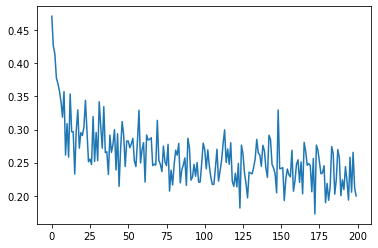

In [204]:
model_params = dict(
                normalize=False,
                learning_rate=1, 
                num_iters=200,
                batch_size=1024,
                momentum=0
)

lg = CustomLogisticRegression()
lg.set_params(**model_params)
lg.fit(normalize(X_train), Y_train)
#{'learning_rate': 0.1, 'num_iters': 200, 'batch_size': 128, 'momentum': 0.5, 'normalize': False}
plt.plot(lg.get_cost_history())


#### Prediction

In [205]:
y_pred = lg.predict(normalize(X_test))
accuracy_score(y_pred, y_test)

0.9214285714285714

#### Import

In [74]:
from attacks import *
from defenses import *

from benchmark import untargeted_attack_benchmark
from benchmark import show_adversarial_sample
from benchmark import benchmark_models
#from benchmark import compare_benchmark_models

In [75]:
def comapre_benchmark_models(X, y_labels, model,  x11, x22, x44, y11, y22, y44, num_steps=10):
    x1, y1, label1 = untargeted_attack_benchmark(X, y_labels, model=model, attack_model=AttackIFGSM, samples=100, num_steps=num_steps)
    #x2, y2, label2 = untargeted_attack_benchmark(X, y_labels, model=model, attack_model=AttackFGSM, samples=100, num_steps=num_steps)
    #x3, y3, label3 = untargeted_attack_benchmark(X, y_labels, model=model, attack_model=AttackNoise, samples=100, num_steps=num_steps)
    #x4, y4, label4 = untargeted_attack_benchmark(X, y_labels, model=model, attack_model=AttackDeepFool, samples=100, num_steps=num_steps)
    # x5, y5, label5 = untargeted_attack_benchmark(X_test_correct, y_labels, model=lg, attack_model=AttackMIFGSM, samples=100)

    fig, ax = plt.subplots(num=None, figsize=(12, 6), dpi=100, facecolor='w')
    plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
    ax.set_title('Perturbation vs Success Rate')
    ax.set_xlabel(r"Perturbation $\epsilon$")
    ax.set_ylabel('Success Rate (%)')

    plt.plot(np.array(x1), y1, linestyle='--', marker='o', markersize=2, color='#00A658', label = label1)
    plt.plot(np.array(x11), y11, linestyle='-', marker='o', markersize=2, color='#00A658', label = "")
    print(np.sum(y11) / len(y11), " : ", np.sum(y1) / len(y1))
    plt.legend()

### Benchmark

In [76]:
# %%time
# defense_random = Randomization(resize_range=(-3, 3), pad_range=(0, 0))
# X_test_randomized = to_vector_shape(defense_random.get_defended(X_test_images))
# y_pred_randomized = lg.predict(normalize(X_test_randomized))
# accuracy_score(y_test, y_pred_randomized)

In [206]:
%%time

best_res = 0
b_d = 0
b_w = 0

count = 0
for d in np.array(range(1, 15)) * 1:
    for w in np.array(range(2, 15)) * 1:
        print(count, "/", 100)
        count += 1
        defense_deflection = PixelDeflection(deflections=d, window=w)
        X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images[0:100]))
        y_pred_deflected = lg.predict(normalize(X_test_deflected))
        #print(accuracy_score(y_test, y_pred_deflected))
        a, b = compare_model_for_two_inputs(X_test, X_test_deflected, Y_test, y_test, model=lg, attack=AttackFGSM, samples=100, num_steps=10, visualize=False)
        if (b > best_res):
            print("yep")
            b_d = d
            b_w = w
            best_res = b


0 / 100
0.125  :  0.124
yep
1 / 100
0.125  :  0.127
yep
2 / 100
0.125  :  0.126
3 / 100
0.125  :  0.127
4 / 100
0.125  :  0.124
5 / 100
0.125  :  0.123
6 / 100
0.125  :  0.124
7 / 100
0.125  :  0.125
8 / 100
0.125  :  0.125
9 / 100
0.125  :  0.126
10 / 100
0.125  :  0.126
11 / 100
0.125  :  0.125
12 / 100
0.125  :  0.124
13 / 100
0.125  :  0.124
14 / 100
0.125  :  0.127
15 / 100
0.125  :  0.126
16 / 100
0.125  :  0.127
17 / 100
0.125  :  0.124
18 / 100
0.125  :  0.124
19 / 100
0.125  :  0.124
20 / 100
0.125  :  0.124
21 / 100
0.125  :  0.125
22 / 100
0.125  :  0.127
23 / 100
0.125  :  0.125
24 / 100
0.125  :  0.123
25 / 100
0.125  :  0.122
26 / 100
0.125  :  0.124
27 / 100
0.125  :  0.126
28 / 100
0.125  :  0.126
29 / 100
0.125  :  0.127
30 / 100
0.125  :  0.124
31 / 100
0.125  :  0.124
32 / 100
0.125  :  0.124
33 / 100
0.125  :  0.124
34 / 100
0.125  :  0.123
35 / 100
0.125  :  0.124
36 / 100
0.125  :  0.124
37 / 100
0.125  :  0.124
38 / 100
0.125  :  0.123
39 / 100
0.125  :  0.124
40

In [207]:
print(b_d, b_w)

10 4


In [ ]:
#6 24

-
0.125  :  0.13


(0.125, 0.13)

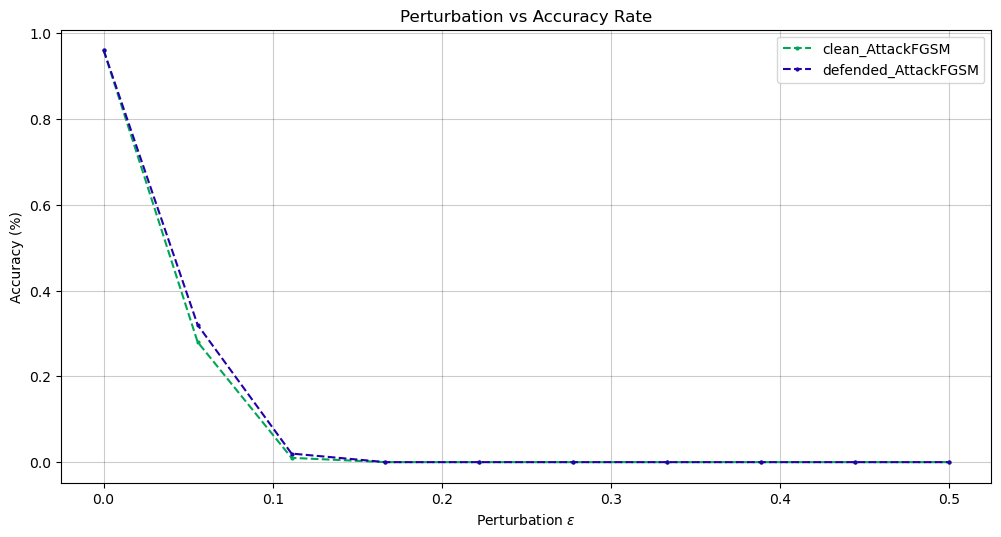

In [209]:
defense_deflection = PixelDeflection(deflections=10, window=4)
X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images[0:100]))
print("-")
compare_model_for_two_inputs(X_test, X_test_deflected, Y_test, y_test, model=lg, attack=AttackFGSM, samples=100, num_steps=10, visualize=True)

In [25]:
defense_deflection = PixelDeflection(deflections=100, window=40)
X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images))
accuracy_score(lg.predict(normalize(X_test_deflected)), y_test)

KeyboardInterrupt: 

In [232]:
%%time

best_res = 1
b_d = 0
b_w = 0

count = 0
for d in np.array(range(1, 3)) * 3:
    for w in np.array(range(1, 3)) * 3:
        print(count, "/", 30*30)
        count += 1
        defense_rand = Randomization(resize_window=d, pad_window=w)
        X_test_rand = to_vector_shape(defense_rand.get_defended(X_test_images[0:100]))
        y_pred_deflected = lg.predict(normalize(X_test_rand))
        #print(accuracy_score(y_test, y_pred_deflected))
        a, b = compare_model_for_two_inputs(X_test, X_test_deflected, Y_test, y_test, model=lg, attack=AttackFGSM, samples=100, num_steps=10, visualize=False)
        if (b < best_res):
            print("yep")
            b_d = d
            d_w = w
            best_res = b


0 / 900
0.188  :  0.184
yep
1 / 900
0.188  :  0.184
2 / 900
0.188  :  0.184
3 / 900
0.188  :  0.184
Wall time: 1.73 s


0.776
0.177  :  0.139


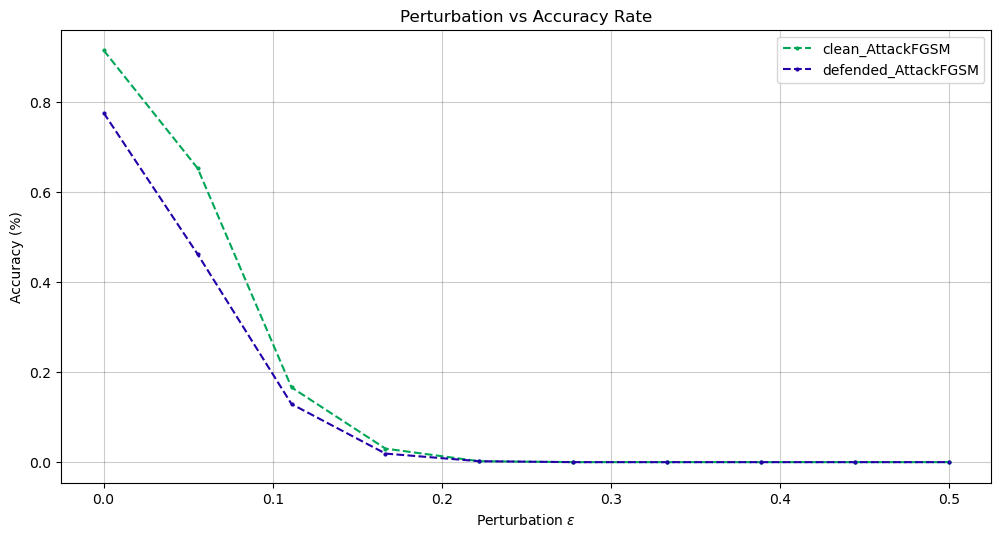

In [135]:
defense_rand = Randomization(resize_window=3, pad_window=0)
X_test_rand = to_vector_shape(defense_rand.get_defended(X_test_images[0:1000]))
print(accuracy_score(lg.predict(normalize(X_test_rand)), y_test[0:1000]))
a, b = compare_model_for_two_inputs(X_test, X_test_rand, Y_test, y_test, model=lg, attack=AttackFGSM, samples=1000, num_steps=10)

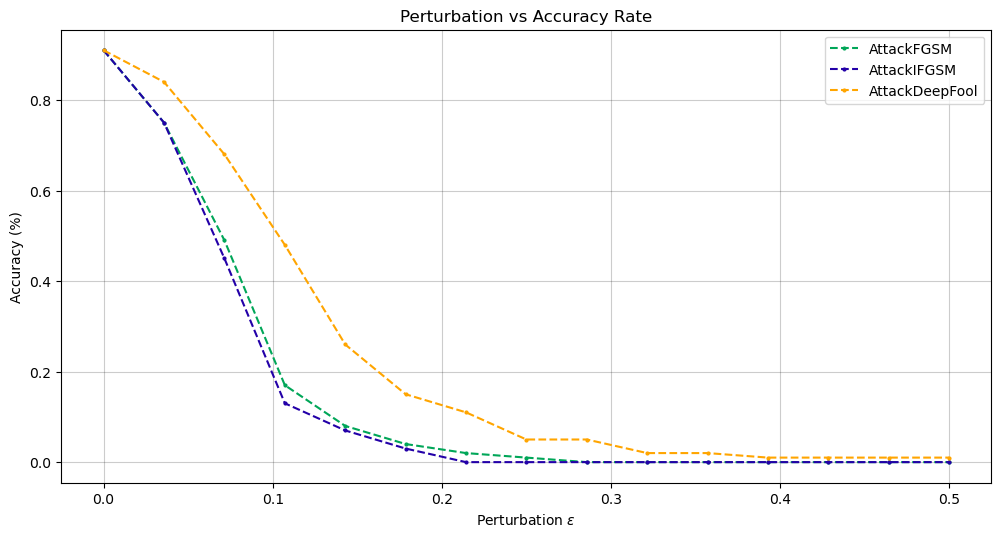

In [120]:
benchmark_defense_models_visual(X_test, Y_test, y_test, model=lg, samples=100, num_steps=15)

In [31]:
%%time
# 100
#10, 4
#30, 4
# 10, 50
# best - 10, 30
# best - 10, 28

#76.4 - # 10, 4
#76.5 - 30, 2
#75.8 - 35, 2
defense_deflection = PixelDeflection(deflections=31, window=2)
X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images))
y_pred_deflected = lg.predict(normalize(X_test_deflected))
print(accuracy_score(y_test, y_pred_deflected))

correct_pred_idx = y_test[:, 0] == y_pred_deflected
comapre_benchmark_models(X_test_deflected[correct_pred_idx], y_labels, lg, x11, x22, x44, y11, y22, y44, num_steps=10)

0.8909523809523809


NameError: name 'x11' is not defined

#### RMAP

In [32]:
# X_test.iloc[0, :].shape

# avg = 0
# for i in range(X_test.shape[0]):
#     attack = AttackFGSM()
#     x_ = normalize(np.expand_dims(X_test.iloc[i, :], axis=0))
#     a = attack.attack(x_, lg.W, lg.b, y, lg.predict, max_norm=1)
#     avg = avg + (x_ - a)
    

In [33]:
# #avg = avg / X_test.shape[0]
# #plt.imshow(avg.reshape(28, 28))
# #avg
# denormalize(avg) / X_test.shape[0]
# rmap = abs((avg / X_test.shape[0]).reshape(28, 28))
# plt.imshow(rmap, 'gray')
# rmap[15]

In [34]:
# x_ = X_test.to_numpy().reshape(-1, 28,28)[0]
# res = pixel_deflection_with_map(x_, avg.reshape(-28, 28), 100, 20)
# plt.imshow(res)

In [35]:
# avg = avg / X_test.shape[0]
# plt.imshow(avg.reshape(28, 28))

### Untargeted Noise Attack

In [36]:
# index = 38
# x = np.expand_dims(X_test[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackNoise, max_norm=1)

### Untargeted FGSM

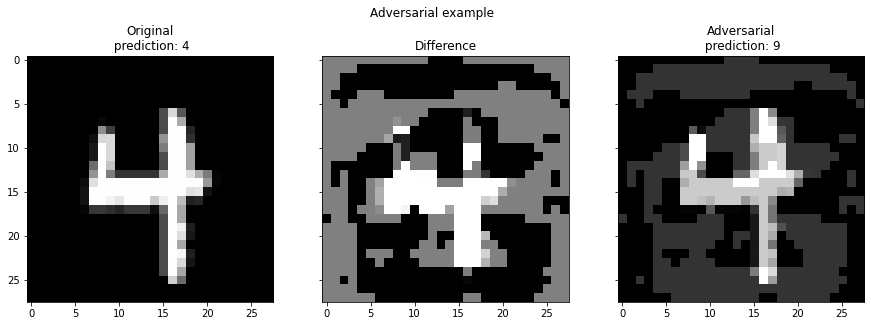

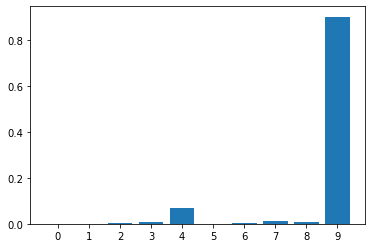

NameError: name 'LA' is not defined

In [37]:
index = 0
x = np.expand_dims(X_test[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackFGSM, max_norm=0.2)

### Untargeted I-FGSM

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_norm=0.04, max_iters=100)

### DeepFool

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackDeepFool, max_norm=0.15, max_iters=12)

### Targeted I-FGSM

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))
# y[9] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackTIFGSM, max_norm=0.2, max_iters=5000)

### Untargeted MI-FGSM

In [ ]:
# index = 123
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackMIFGSM, max_norm=1, max_iters=5000)

#### Model evaluation

In [ ]:
# y_real = np.array(y_test.iloc[:, 0])

# comp = pd.DataFrame({"y_pred": y_pred, "y_real": y_real})
# print(comp.head(20))

In [ ]:
##### from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# r2 = r2_score(y_real, y_pred)
# accuracy = int(sum(y_real == y_pred) / len(y_pred) * 100)

# print(f'Coefficient of determination: {r2}')
# print(f"Accuracy: {accuracy}%")